In [1]:
####### importing all required packages here ##########
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from qiskit import *
from qiskit import BasicAer
from qiskit.aqua.algorithms import QAOA, NumPyMinimumEigensolver, VQE
from qiskit.optimization.algorithms import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer, GroverOptimizer
from qiskit.optimization import QuadraticProgram
from qiskit.aqua import QuantumInstance
from qiskit.aqua.components.optimizers import SPSA
from qiskit.circuit.library import TwoLocal

In [2]:
############# Creating edge matrix #############

def create_edge_matrix(number_of_points, probability):
    edge_matrix = np.ones((number_of_points,number_of_points))
    for i in range(0,number_of_points):
        for j in range(i,number_of_points):
            if random.random()>probability or i==j:
                edge_matrix[i,j]=0
                edge_matrix[j,i]=0
    return edge_matrix

create_edge_matrix(5, 0.5)

array([[0., 0., 1., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 1., 0., 1., 1.],
       [1., 0., 1., 0., 1.],
       [0., 0., 1., 1., 0.]])

In [3]:
############ Creating and exporting Quadratic program ############

def Create_quadratic_program(n, edge_matrix):
    qubo = QuadraticProgram()
    linear_coefficients = list()
    summation_terms = dict()
    for i in range(n):
        qubo.binary_var('x'+ str(i))
        linear_coefficients.append(1)
    for i in range(n-1):
        for j in range(i+1,n):
            if edge_matrix[i,j] == 1:
                summation_terms[('x'+str(i),'x'+str(j))] = summation_terms.get(('x'+str(i),'x'+str(j)), -4*n)
    qubo.maximize(linear= linear_coefficients, quadratic= summation_terms)
    #print(qubo.export_as_lp_string())
    op, offset = qubo.to_ising()
    return op, offset, qubo
Create_quadratic_program(5, create_edge_matrix(5,0.5))

(SummedOp([PauliOp(Pauli(z=[True, False, False, False, False], x=[False, False, False, False, False]), coeff=-14.5), PauliOp(Pauli(z=[False, True, False, False, False], x=[False, False, False, False, False]), coeff=-14.5), PauliOp(Pauli(z=[False, False, True, False, False], x=[False, False, False, False, False]), coeff=-14.5), PauliOp(Pauli(z=[False, False, False, True, False], x=[False, False, False, False, False]), coeff=-9.5), PauliOp(Pauli(z=[False, False, False, False, True], x=[False, False, False, False, False]), coeff=-14.5), PauliOp(Pauli(z=[True, True, False, False, False], x=[False, False, False, False, False]), coeff=5.0), PauliOp(Pauli(z=[False, True, True, False, False], x=[False, False, False, False, False]), coeff=5.0), PauliOp(Pauli(z=[True, False, False, True, False], x=[False, False, False, False, False]), coeff=5.0), PauliOp(Pauli(z=[False, False, True, True, False], x=[False, False, False, False, False]), coeff=5.0), PauliOp(Pauli(z=[True, False, False, False, True

In [4]:
######### Solving using NumpyeigenSolver ############

def result_exact(qubo):
    exact_mes = NumPyMinimumEigensolver()
    exact = MinimumEigenOptimizer(exact_mes)
    exact_result = exact.solve(qubo)
    return exact_result.fval
op, offset, qubo = Create_quadratic_program(16, create_edge_matrix(16,0.5))
result_exact(qubo)

############ working fine till 16 only ##############

4.0

In [5]:
######### Function for getting cost and time vs n using NumpyeigenSolver ##########

def get_cost_and_time_numpy(n1, n2):
    cost_vs_n_fromnumpy = list()
    time_vs_n_fromnumpy = list()
    cost = list()
    tim = list()
    for j in range(n1,n2):
        for i in range(5):
            initial_time = time.time()
            op, offset, qubo = Create_quadratic_program(16, create_edge_matrix(16,0.5))
            cost.append(result_exact(qubo))
            final_time = time.time()
            tim.append(final_time - initial_time)
        average_cost = sum(cost)/5
        average_time = sum(tim)/5
        (x, y) = (j, average_cost)
        (x, z) = (j, average_time)
        cost_vs_n_fromnumpy.append((x, y))
        time_vs_n_fromnumpy.append((x, z))
        print("n=", x, "cost=", y, "time=", z)
        cost.clear()
        tim.clear()
    return cost_vs_n_fromnumpy, time_vs_n_fromnumpy

In [6]:
######### Solving using QAOA ########

def result_qaoa(qubo):
    qaoa_mes = QAOA(quantum_instance=BasicAer.get_backend('qasm_simulator'))
    qaoa = MinimumEigenOptimizer(qaoa_mes)
    qaoa_result = qaoa.solve(qubo)
    return qaoa_result.fval
#op, offset, qubo = Create_quadratic_program(5, create_edge_matrix(5,0.5))
#result_qaoa(qubo)

In [7]:
######### Function for getting cost and time vs n using QAOA ##########

def get_cost_and_time_QAOA(n1, n2):
    cost_vs_n_fromQAOA = list()
    time_vs_n_fromQAOA = list()
    cost = list()
    tim = list()
    for j in range(n1,n2):
        for i in range(5):
            initial_time = time.time()
            op, offset, qubo = Create_quadratic_program(5, create_edge_matrix(5,0.5))
            cost.append(result_qaoa(qubo))
            final_time = time.time()
            tim.append(final_time - initial_time)
        average_cost = sum(cost)/5
        average_time = sum(tim)/5
        (x, y) = (j, average_cost)
        (x, z) = (j, average_time)
        cost_vs_n_fromQAOA.append((x, y))
        time_vs_n_fromQAOA.append((x, z))
        print("n=", x, "cost=", y, "time=", z)
        cost.clear()
        tim.clear()
    return cost_vs_n_fromQAOA, time_vs_n_fromQAOA

In [8]:
####### decimal to binary converter #######

def dec_to_bin(decimal, no_bits):
    binary = np.zeros((no_bits))
    for i in range(no_bits-1,-1,-1):
        #print(decimal, i)
        if int(decimal/(2**i)):
            binary[i]=1
        decimal = decimal%(2**i)
    return binary[::-1]
#dec_to_bin(5,4)

In [9]:
######## solving using Brute force ###########

def brute_force(n, edge_matrix):
    best_cost = 0
    best_case =None
    flag = True
    for i in range(2**n):
        binary = dec_to_bin(i,n)
        ans = sum(binary)
        for j in range(n-1):
            for k in range(j+1,n):
                if edge_matrix[j,k]==1:
                    ans = ans - 4*n*binary[j]*binary[k]
        if ans>best_cost:
            best_cost = ans
            #best_case = binary
    return best_cost
#brut_force(8, create_edge_matrix(8,0.5))

In [10]:
######### Function for getting cost and time vs n using brute force ##########

def get_cost_and_time_vs_n(n1, n2):
    cost_vs_n = list()
    time_vs_n = list()
    cost = list()
    tim = list()
    for j in range(n1,n2):
        for i in range(5):
            initial_time = time.time()
            cost.append(brute_force(j, create_edge_matrix(j, 0.5)))
            final_time = time.time()
            tim.append(final_time - initial_time)
        average_cost = sum(cost)/5
        average_time = sum(tim)/5 
        (x, y) = (j, average_cost)
        (x, z) = (j, average_time)
        cost_vs_n.append((x, y))
        time_vs_n.append((x, z))
        print("n=", x, "cost=", y, "time=", z)
        cost.clear()
        tim.clear()
    return cost_vs_n, time_vs_n

In [11]:
########### solving using VQE #########

def using_vqe(qubo):
    vqe = VQE(quantum_instance=BasicAer.get_backend('qasm_simulator'))
    vqe_optimizer = MinimumEigenOptimizer(vqe)
    result = vqe_optimizer.solve(qubo)
    return result.fval
#op, offset, qubo = Create_quadratic_program(5, create_edge_matrix(5,0.5))
#using_vqe(qubo)

In [12]:
######### Function for getting cost and time vs n using VQE ##########

def get_cost_and_time_VQE(n1, n2):
    cost_vs_n_fromVQE = list()
    time_vs_n_fromVQE = list()
    cost = list()
    tim = list()
    for j in range(n1,n2):
        for i in range(5):
            initial_time = time.time()
            op, offset, qubo = Create_quadratic_program(5, create_edge_matrix(5,0.5))
            cost.append(using_vqe(qubo))
            final_time = time.time()
            tim.append(final_time - initial_time)
        average_cost = sum(cost)/5
        average_time = sum(tim)/5
        (x, y) = (j, average_cost)
        (x, z) = (j, average_time)
        cost_vs_n_fromVQE.append((x, y))
        time_vs_n_fromVQE.append((x, z))
        print("n=", x, "cost=", y, "time=", z)
        cost.clear()
        tim.clear()
    return cost_vs_n_fromVQE, time_vs_n_fromVQE

In [13]:
######## solving Using Grover ##########

def using_grover(n,qubo):
    backend = BasicAer.get_backend('qasm_simulator')
    grover_optimizer = GroverOptimizer(n, num_iterations=10, quantum_instance= backend)
    results = grover_optimizer.solve(qubo)
    return results
op, offset, qubo = Create_quadratic_program(5, create_edge_matrix(5,0.5))
#using_grover(5,qubo)

In [14]:
######## getting cost and time from every method #########

print("Cost and time using Brute Force")
cost_vs_n, time_vs_n = get_cost_and_time_vs_n(4, 17)

print("")

print("Cost and time using NumpyEigenSolver")
cost_vs_n_fromeigensolver, time_vs_n_fromeigensolver = get_cost_and_time_numpy(4, 17)

print("")

print("Cost and time using VQE")
cost_vs_n_fromVQE, time_vs_n_fromVQE = get_cost_and_time_VQE(4, 17)

print("")

print("Cost and time using QAOA")
cost_vs_n_fromQAOA, time_vs_n_fromQAOA = get_cost_and_time_QAOA(4, 17)

Cost and time using Brute Force
n= 4 cost= 2.8 time= 0.0001998424530029297
n= 5 cost= 2.8 time= 0.0007982254028320312
n= 6 cost= 3.0 time= 0.0023930549621582033
n= 7 cost= 3.4 time= 0.004788112640380859
n= 8 cost= 3.4 time= 0.010570621490478516
n= 9 cost= 3.8 time= 0.02075328826904297
n= 10 cost= 4.0 time= 0.04687457084655762
n= 11 cost= 4.0 time= 0.10870928764343261
n= 12 cost= 4.2 time= 0.2792529106140137
n= 13 cost= 4.6 time= 0.6716873168945312
n= 14 cost= 4.4 time= 1.459475612640381
n= 15 cost= 4.8 time= 3.3195346355438233
n= 16 cost= 4.6 time= 7.258779573440552

Cost and time using NumpyEigenSolver
n= 4 cost= 5.0 time= 0.4571860313415527
n= 5 cost= 4.8 time= 0.4481990337371826
n= 6 cost= 4.4 time= 0.4593649864196777
n= 7 cost= 4.6 time= 0.44301471710205076
n= 8 cost= 4.4 time= 0.4575820446014404
n= 9 cost= 4.4 time= 0.4645508289337158
n= 10 cost= 5.0 time= 0.44282965660095214
n= 11 cost= 4.4 time= 0.43423829078674314
n= 12 cost= 4.8 time= 0.4555854320526123
n= 13 cost= 5.0 time= 0

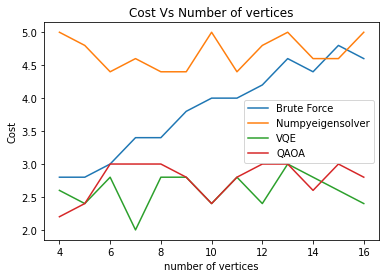

In [17]:
#### plotting cost vs n #####
plt.title("Cost Vs Number of vertices")
plt.ylabel('Cost')
plt.xlabel('number of vertices')
x, y = zip(*cost_vs_n)
plt.plot(x, y, label = 'Brute Force')
x, y = zip(*cost_vs_n_fromeigensolver)
plt.plot(x, y, label = 'Numpyeigensolver')
x, y = zip(*cost_vs_n_fromVQE)
plt.plot(x, y, label = 'VQE')
x, y = zip(*cost_vs_n_fromQAOA)
plt.plot(x, y, label = 'QAOA')
plt.legend()


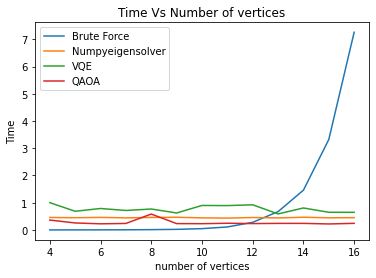

In [18]:
######### Plotting Time Vs n ########
plt.title("Time Vs Number of vertices")
plt.ylabel('Time')
plt.xlabel('number of vertices')
x, y = zip(*time_vs_n)
plt.plot(x, y, label = 'Brute Force')
x, y = zip(*time_vs_n_fromeigensolver)
plt.plot(x, y, label = 'Numpyeigensolver')
x, y = zip(*time_vs_n_fromVQE)
plt.plot(x, y, label = 'VQE')
x, y = zip(*time_vs_n_fromQAOA)
plt.plot(x, y, label = 'QAOA')
plt.legend()